# Classification

## Import Libraries

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import os

In [ ]:
import zipfile
if len(os.listdir("/content/drive/MyDrive/Fish")) == 0:
    with zipfile.ZipFile("/content/drive/MyDrive/Fish_Dataset.zip", 'r') as zip_ref:
        zip_ref.extractall("/content/drive/MyDrive/Fish")

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torch.autograd import Variable
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import pandas as pd
import PIL
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
import warnings
warnings.filterwarnings("ignore") 

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
path = '/content/drive/MyDrive/Fish/Fish_Dataset/Fish_Dataset'

## Sample Images

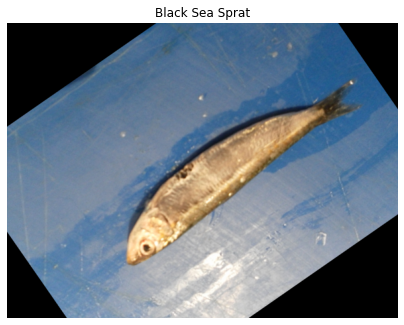

In [ ]:
fig = plt.figure(figsize=(7,7))
img = PIL.Image.open("/content/drive/MyDrive/Fish/Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat/00001.png")
plt.imshow(img)
plt.title("Black Sea Sprat")
plt.axis('off')
plt.show()

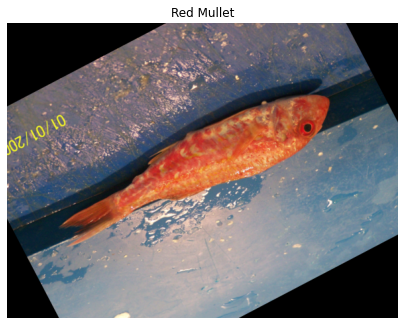

In [ ]:
fig = plt.figure(figsize=(7,7))
img = PIL.Image.open("/content/drive/MyDrive/Fish/Fish_Dataset/Fish_Dataset/Red Mullet/Red Mullet/00001.png")
plt.imshow(img)
plt.title("Red Mullet")
plt.axis('off')
plt.show()

## Preparing Data

In [ ]:
classes = []
for directory in os.listdir(path):
    classes.append(directory)

print(classes)

['Black Sea Sprat', 'Gilt-Head Bream', 'Hourse Mackerel', 'Red Mullet', 'Red Sea Bream', 'Sea Bass', 'Shrimp', 'Striped Red Mullet', 'Trout']


In [ ]:
image_dir = {}
for i in classes:
    image_dir[i] = [os.path.join(path,i,i,j) for j in os.listdir(os.path.join(path,i,i))]

In [ ]:
img_class = []
img_name = []
for i in image_dir.keys():
    for j in image_dir[i]:
        img_class.append(i)
        img_name.append(j)

In [ ]:
data = {'img_name':img_name, 'label': img_class}

In [ ]:
df = pd.DataFrame(data)
df.head()

,img_name,label
0,/content/drive/MyDrive/Fish/Fish_Dataset/Fish_...,Black Sea Sprat
1,/content/drive/MyDrive/Fish/Fish_Dataset/Fish_...,Black Sea Sprat
2,/content/drive/MyDrive/Fish/Fish_Dataset/Fish_...,Black Sea Sprat
3,/content/drive/MyDrive/Fish/Fish_Dataset/Fish_...,Black Sea Sprat
4,/content/drive/MyDrive/Fish/Fish_Dataset/Fish_...,Black Sea Sprat


In [ ]:
str_to_int = {i[0]:int(i[1]) for i in zip(classes,list(range(9)))}
print(str_to_int)

{'Black Sea Sprat': 0, 'Gilt-Head Bream': 1, 'Hourse Mackerel': 2, 'Red Mullet': 3, 'Red Sea Bream': 4, 'Sea Bass': 5, 'Shrimp': 6, 'Striped Red Mullet': 7, 'Trout': 8}


In [ ]:
int_to_str = {int(i[1]):i[0] for i in zip(classes,list(range(9)))}
print(int_to_str)

{0: 'Black Sea Sprat', 1: 'Gilt-Head Bream', 2: 'Hourse Mackerel', 3: 'Red Mullet', 4: 'Red Sea Bream', 5: 'Sea Bass', 6: 'Shrimp', 7: 'Striped Red Mullet', 8: 'Trout'}


## Building Dataloader

In [ ]:
transform = transforms.Compose([transforms.Resize(224),
                                transforms.ToTensor(),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(20),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                ])

In [ ]:
class FishData(Dataset):
    def __init__(self, data, path, transform=None):
        self.data = data
        self.path = path
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image_path = self.data.img_name[idx]
        image = PIL.Image.open(image_path)
        class_name = self.data.label[idx]
        label = str_to_int[class_name]
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [ ]:
dataset = FishData(df, path, transform)

In [ ]:
train_size = int(len(dataset)*0.8)
val_size = int(len(dataset)*0.2)
train_data, val_data = torch.utils.data.random_split(dataset, [train_size, val_size])

In [ ]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

## Building The Model

In [ ]:
vgg = models.vgg16(pretrained=True)

In [ ]:
class Model(nn.Module):
    def __init__(self, features, output_features):
        super(Model, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Linear(32256, 512),
            nn.Dropout(),
            nn.Linear(512,512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, output_features)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
for param in vgg.parameters():
    param.requires_grad = False

In [ ]:
model = Model(vgg.features, len(classes))

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

## Training The Mode

In [ ]:
epochs = 15
model = model.to(device)
best_acc = 0
for epoch in tqdm_notebook(range(epochs)):
    model.train()
    correct = 0
    for images, labels in train_loader:
        images = Variable(images)
        labels = Variable(labels)
        
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()
    model.eval()
    with torch.no_grad():
        val_correct = 0
        val_total = 0
        for images, labels in val_loader:
            images = Variable(images)
            labels = Variable(labels)
            
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum()
        
        val_acc = 100 * val_correct / val_total
    train_acc = 100*correct / len(train_data)

    if val_acc > best_acc:
        torch.save(model.state_dict(), '/content/drive/MyDrive/Fish/model.pt')
        best_acc = val_acc
    print('Epoch [{}/{}], Loss {:.4f}, Train Accuracy: {:.4f}%, Val Accuracy: {:.4f}%'.format(epoch+1,
                                            epochs, loss.item(), train_acc, val_acc))

Epoch [1/15], Loss 0.5834, Train Accuracy: 79.2917%, Val Accuracy: 95.3889%
Epoch [2/15], Loss 0.2012, Train Accuracy: 91.3195%, Val Accuracy: 96.5556%
Epoch [3/15], Loss 0.4619, Train Accuracy: 94.0278%, Val Accuracy: 99.2222%
Epoch [4/15], Loss 0.1486, Train Accuracy: 95.9445%, Val Accuracy: 98.5556%
Epoch [5/15], Loss 0.0000, Train Accuracy: 95.2917%, Val Accuracy: 97.0556%
Epoch [6/15], Loss 3.9680, Train Accuracy: 96.1806%, Val Accuracy: 99.0556%
Epoch [7/15], Loss 0.2588, Train Accuracy: 96.7083%, Val Accuracy: 98.8889%
Epoch [8/15], Loss 3.4284, Train Accuracy: 97.0139%, Val Accuracy: 99.5000%
Epoch [9/15], Loss 2.8129, Train Accuracy: 97.5695%, Val Accuracy: 99.7778%
Epoch [10/15], Loss 0.0000, Train Accuracy: 96.5417%, Val Accuracy: 99.0000%
Epoch [11/15], Loss 4.7810, Train Accuracy: 97.5833%, Val Accuracy: 99.1667%
Epoch [12/15], Loss 0.0021, Train Accuracy: 98.0833%, Val Accuracy: 99.6667%
Epoch [13/15], Loss 0.0000, Train Accuracy: 98.3195%, Val Accuracy: 99.4445%
Epoch [1

## Loading The Best Model

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/Fish/model.pt"))

<All keys matched successfully>

## Testing The Model

In [ ]:
model = model.to(device)
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for images, labels in val_loader:
        images = Variable(images)
        labels = Variable(labels)
        
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_pred += predicted.cpu()
        y_true += labels.cpu()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
print(classification_report(y_true, y_pred, target_names=classes))

                    precision    recall  f1-score   support

   Black Sea Sprat       1.00      0.99      1.00       190
   Gilt-Head Bream       1.00      0.99      1.00       227
   Hourse Mackerel       0.99      0.99      0.99       193
        Red Mullet       0.95      1.00      0.97       176
     Red Sea Bream       0.98      1.00      0.99       185
          Sea Bass       1.00      1.00      1.00       215
            Shrimp       0.95      1.00      0.98       191
Striped Red Mullet       1.00      0.91      0.95       215
             Trout       1.00      1.00      1.00       208

          accuracy                           0.99      1800
         macro avg       0.99      0.99      0.99      1800
      weighted avg       0.99      0.99      0.99      1800



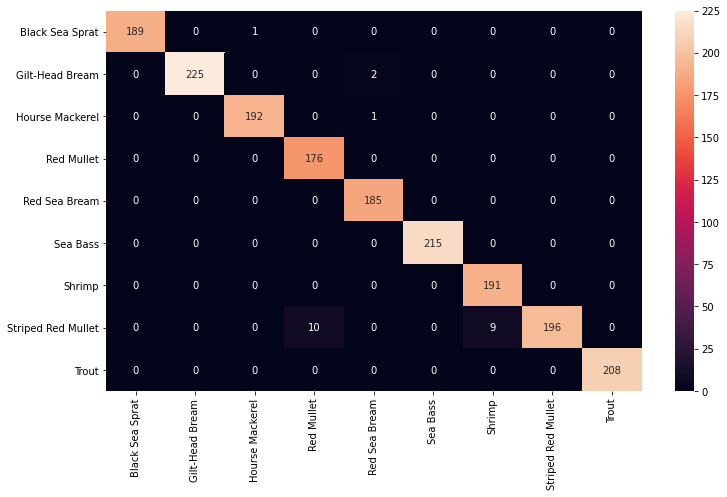

In [ ]:
cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index = [i for i in classes],
                  columns = [i for i in classes])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm,annot=True,annot_kws={"size": 10}, fmt='g')